# ML Exercise 1-1
## Question 1
By Gholamreza Dar

https://gholamrezadar.ir/

Nov 2021


Questions available at : [Github Link](https://github.com/Gholamrezadar/machine-learning-exercises/blob/main/ML-HW01.pdf)


How to Run:
Runtime > Run all(ctrl+f9)

## Hyper Parameters

In [45]:
#@title Hyper Parameters
#@markdown Main :
max_iterations = 10000  #@param {type: "number"}
train_test_split = 0.7 #@param {type: "number"}

#@markdown Basic Example :
basic_polynomial_degree = 10 #@param {type: "number"}
basic_iterations = 1000  #@param {type: "number"}
basic_learning_rate = 2.3 #@param {type: "number"}
basic_decay = 5e-9 #@param {type: "number"}

## Loading Data

In [46]:
# Download dataset
!wget https://raw.githubusercontent.com/Gholamrezadar/machine-learning-exercises/main/dataset1/dataset1.csv

--2021-11-23 05:46:33--  https://raw.githubusercontent.com/Gholamrezadar/machine-learning-exercises/main/dataset1/dataset1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12074 (12K) [text/plain]
Saving to: ‘dataset1.csv.1’

dataset1.csv.1      100%[===================>]  11.79K  --.-KB/s    in 0s      

2021-11-23 05:46:33 (83.2 MB/s) - ‘dataset1.csv.1’ saved [12074/12074]



In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

# use seaborn
sns.set()

# Load the data using pandas
df = pd.read_csv("dataset1.csv")

In [48]:
# Show a sample of the data
df.head()

,x,y
0,0.097627,0.626964
1,0.430379,0.846452
2,0.205527,0.756017
3,0.089766,0.427504
4,-0.152690,-1.335228


In [49]:
# Show a description of the data (might be useful later)
df.describe()

,x,y
count,300.000000,300.000000
mean,0.007005,0.412755
std,0.580948,1.021100
min,-0.990609,-1.547934
25%,-0.504657,-0.361192
50%,0.045096,0.316442
75%,0.460611,1.092441
max,0.997694,3.186153


## Helper functions

In [50]:
# Suppress some warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

#### Loss Functions

In [51]:
# h(theta) =  theta transpose * X
def hypothesis(X, theta):
  y1 = theta*X
  return np.sum(y1, axis=1)

def MSE(X, y, theta):
  y_hat = hypothesis(X, theta)
  m = len(X)
  return sum((y_hat-y)**2)/(2*m)

def RMSE(X, y, theta):
  y_hat = hypothesis(X, theta)
  m = len(X)
  return np.sqrt(sum((y_hat-y)**2)/(2*m)) 

def MAE(X, y, theta):
  y_hat = hypothesis(X, theta)
  m = len(X)
  return sum(np.abs((y_hat-y)))/(2*m)

# Loss functions Derivatives
def MSE_prim(X, y, i, theta):
  y_hat = hypothesis(X, theta)
  Xi = X.iloc[:, i]
  m = len(X)
  return sum((y_hat-y) * Xi) / m

def RMSE_prim(X, y, i, theta):
  # src : https://math.stackexchange.com/questions/4065532/rmse-derivatives
  mse = MSE(X, y, theta)
  mse_prim = MSE_prim(X, y, i, theta)

  return mse_prim / 2 / np.sqrt(mse)

def MAE_prim(X, y, i, theta):
  # src : https://stats.stackexchange.com/questions/312737/mean-absolute-error-mae-derivative
  # src2 : https://github.com/chenxingwei/machine_learning_from_scratch/blob/master/algorithm/2.linearRegressionGradientDescent.md
  y_hat = hypothesis(X, theta)
  # print(np.sum((X.T*(np.sign(y_hat-y)/len(X))), axis=1)[i])
  return np.sum((X.T*(np.sign(y_hat-y)/len(X))), axis=1)[i]


#### Gradient Descent

In [52]:
def gradientDescent(X, y, theta, lr, iteration, X_valid, y_valid, loss_fn = MSE, loss_fn_prim = MSE_prim, decay=0.0):
  # Training loss per iteration history
  train_loss_history = []
  # Validation loss per iteration history
  validation_loss_history = []
  # weights progression towards the optimal value
  theta_history = []

  # Progress bar
  with tqdm(total=iteration) as pbar:
    for itera in range(iteration):
      # TODO : Learning rate decay
      lr = lr * 1/(1 + decay * itera)

      for i in range(0, len(X.columns)):
        # partial derivative of loss function with respect to Xi
        gradient = loss_fn_prim(X, y, i, theta)

        # Actual "Gradient Descent" !
        theta[i] -= lr * gradient
      
      # Calculating the loss after each iteration
      # of updating the weights using Gradient Descent
      loss = loss_fn(X, y, theta)
      if X_valid is not None and y_valid is not None:
        validation_loss = loss_fn(X_valid, y_valid, theta)

      # Save the history of loss and weights
      train_loss_history.append(loss)
      if X_valid is not None and y_valid is not None:
        validation_loss_history.append(validation_loss)
      theta_history.append(theta.copy())

      # Update progress bar
      pbar.update(1)

  history = {"training_loss":train_loss_history,
             "validation_loss":validation_loss_history,
             "weights":theta_history}
  # returns loss history, latest loss, weights
  print(f"training_loss : {round(train_loss_history[-1],4)} | validation_loss : {round(validation_loss_history[-1],4)}")
  return history, loss, theta

In [53]:
# Add the polynomial's terms as features
# so that the univariate non-linear regression
# becomes a multivariate linear regression
# where every polynomial term is a feature for
# the linear regression
def polynomial_to_linear_regression(X, polynomial_degree):
  for i in range(2, 1 + polynomial_degree):
    X['x'+str(i)] = X['x']**i

In [54]:
#  helper function used to plot a polynomial
def polyCoefficients(x, coeffs):
    o = len(coeffs)
    y = 0
    for i in range(o):
        y += coeffs[i]*x**i
    return y

#### Normal Equation

In [55]:
def normalEquation(X, y):
  # (X^T X)^-1 X^T Y
  XTX = np.dot(X.T,X)
  XTX_inverse = np.linalg.inv(XTX)
  XTY = np.dot(X.T,y)
  theta = np.dot(XTX_inverse, XTY)
  return theta

def regularizedNormalEquation(X, y, lambd=0.1):
  # (X^T X + lambda I)^-1 X^T Y
  XTX = np.dot(X.T,X) + np.dot(np.identity(X.shape[1]),lambd)
  XTX_inverse = np.linalg.inv(XTX)
  XTY = np.dot(X.T,y)
  theta = np.dot(XTX_inverse, XTY)
  return theta

#### Plotting related

##### def plot_curve( )

In [56]:
# Plots a polynomial on top of the original data
def plot_curve(X, y, theta, c='r', title='', resolution=200):
  # Don't try this at home
  import warnings
  warnings.simplefilter(action="ignore", category=FutureWarning)
  
  plt.figure()
  plt.title(title)
  # Plot the original data
  plt.scatter(x=X['x'],y= y)

  x = np.linspace(-1, 1, resolution)
  # Plot the fitted polynomial over the data
  plt.plot(x, polyCoefficients(x, theta), color=c, linewidth=4)

  plt.show()

##### def plot_loss( )

In [57]:
# Plots validation and training losses per iteration
def plot_loss(history, title='', starting_iter=0):
  # Don't try this at home
  import warnings
  warnings.simplefilter(action="ignore", category=FutureWarning)
  
  fig, ax = plt.subplots()
  plt.title(title)

  # X = iterations range
  x = np.linspace(0, iterations, iterations)
  
  # 1. Training_loss - iteration curve (Red)
  sns.lineplot(x[starting_iter:], history["training_loss"][starting_iter:], color='r')
  # 2. Validation_loss - iteration curve (green)
  sns.lineplot(x[starting_iter:], history["validation_loss"][starting_iter:], color='g')

  ax.legend(labels=["training", "validation"])

  plt.show()

##### def plot_lr( )

In [58]:
def plot_lr(lr=0.1, iterations=1000, decay=None, title='learning_rate'):
  # Don't try this at home
  import warnings
  warnings.simplefilter(action="ignore", category=FutureWarning)
  
  _lrs = []
  # Iterations
  _iterations = iterations
  # Initial lr
  _lr0 = lr
  _decay = 0
  # Decay
  if decay is None:
    _decay = _lr0/_iterations
  else:
    _decay = decay

  # Simulate gradient descents main loop
  _lr = _lr0
  for i in range(_iterations):
    _lr = _lr * 1/(1 + _decay * i)
    _lrs.append(_lr)

  _x = list(range(_iterations))
  _y = _lrs

  plt.figure()
  plt.title(title)
  plt.plot(_x, _y)
  plt.show()

##### def plot_every_curve( )

In [91]:
def plot_every_curve(X, y, thetas,line_widths=[1, 1], resolution=100, i_max=3, j_max=3, dpi=72):
  # Don't try this at home
  import warnings
  warnings.simplefilter(action="ignore", category=FutureWarning)

  plt.figure()
  fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16,10), constrained_layout=True)
  fig.dpi = dpi
  # fig.subplots_adjust(hspace=0.6)

  # Helper lists for accessing the current config
  fn_labels = ["MAE", "RMSE", "MSE"]
  deg_labels = ["degree 10","degree 8","degree 5"]

  # Used to plot the fitted polynomial in the range[-1,1]
  x = np.linspace(-1, 1, resolution)

  # Plotting every case in a 3 by 3 grid
  for i in range(i_max):
    for j in range(j_max):

      # 1. plot the original data (Dots)
      sns.scatterplot(x=X["x"], y=y, ax=axes[i,j] )# ,s=70, color='darkgray')

      # 2. Plot a curve with an earlier iteration theta [1] (Red)
      theta = thetas[i][j][1]
      sns.lineplot(x, polyCoefficients(x, theta), color='r', ax=axes[i,j], linewidth=line_widths[1])

      # 3. Plot a curve with the Last iteration theta [0] (Green)
      theta = thetas[i][j][0]
      sns.lineplot(x, polyCoefficients(x, theta), color='g', ax=axes[i,j], linewidth=line_widths[0])

      # Legends and titles
      axes[i,j].legend(labels=[f"{other_iteration_to_display} iters", f"{int(iterations)} iters"])
      axes[i,j].set_title(f"train_loss:{round(losses[i][j][0],3)}   valid_loss:{round(losses[i][j][1],3)}")

      # Matplotlib related code
      axes[i,j].xaxis.set_ticklabels([])
      axes[i,j].yaxis.set_ticklabels([])
      axes[i,j].set_xlabel(fn_labels[j])
      axes[i,j].set_ylabel(deg_labels[i])

  plt.show()

##### def plot_every_case_loss( )

In [60]:
def plot_every_case_loss(histories, starting_iter=0, i_max=3, j_max=3, dpi=72):
  # Don't try this at home
  import warnings
  warnings.simplefilter(action="ignore", category=FutureWarning)

  plt.figure()
  fig, axes = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(16,10), constrained_layout=True)
  fig.dpi = dpi

  # Helper lists for accessing the current config
  fn_labels = ["MAE", "RMSE", "MSE"]
  deg_labels = ["degree 10","degree 8","degree 3"]

  # X = iterations range
  x = np.linspace(0, iterations, iterations)

  # Plotting every case in a 3 by 3 grid
  for i in range(i_max):
    for j in range(j_max):

      # 1. Training_loss - iteration curve (Red)
      sns.lineplot(x[starting_iter:], histories[i][j][0]["training_loss"][starting_iter:], color='r', ax=axes[i,j])
      # 2. Validation_loss - iteration curve (green)
      sns.lineplot(x[starting_iter:], histories[i][j][0]["validation_loss"][starting_iter:], color='g', ax=axes[i,j])

      # Legends
      axes[i,j].legend(labels=[f"training loss", f"validation loss"])

      # Matplotlib related code
      axes[i,j].set_xlabel(fn_labels[j])
      axes[i,j].set_ylabel(deg_labels[i])

  plt.show()

##### def plot_normal_equations( )

In [61]:
# Plots a polynomial on top of the original data
def plot_normal_equations(X, y, c='r', title='', resolution=200, dpi=72):
  # Don't try this at home
  import warnings
  warnings.simplefilter(action="ignore", category=FutureWarning)

  fig, ax = plt.subplots()
  plt.title(title)
  fig.dpi=dpi

  # Plot the original data
  sns.scatterplot(x=X['x'], y=y, size=1, color='darkgray')

  x = np.linspace(-1, 1, resolution)

  # calculate theta for each method
  normal_theta = normalEquation(X_train_copy, y_train)
  reg_normal_theta1 = regularizedNormalEquation(X_train_copy, y_train, lambd=0.075)
  reg_normal_theta2 = regularizedNormalEquation(X_train_copy, y_train, lambd=0.75)
  reg_normal_theta4 = regularizedNormalEquation(X_train_copy, y_train, lambd=7.5)

  # Plot the fitted polynomial over the data
  plt.plot(x, polyCoefficients(x, normal_theta), linewidth=2)
  plt.plot(x, polyCoefficients(x, reg_normal_theta1), linewidth=2)
  plt.plot(x, polyCoefficients(x, reg_normal_theta2), linewidth=2)
  plt.plot(x, polyCoefficients(x, reg_normal_theta4), linewidth=2)

  ax.legend(labels=["No Regularization", "λ=0.075", "λ=0.75", "λ=7.5"])
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  plt.show()

## Part 1 - Plotting the data

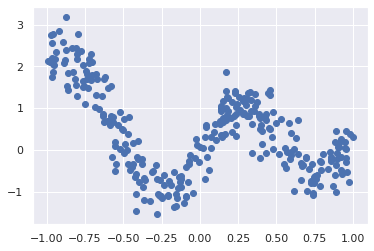

In [62]:
# Plot the data using matplotlib
plt.scatter(x=df['x'],y=df['y'])
plt.show()

## Part 2 - Shuffle

In [63]:
def plot_colorize(df):
  '''
  Assigns 'red' color to the first half of the data
  and 'blue' to the rest

  If the data is well shuffled we should see random red 
  and blue circles everywhere.

  If the data is NOT well shuffled we might see a pattern between
  circles' position and their color.
  '''

  df_red = df.loc[df.index<df.shape[0]/2]
  df_blue = df.loc[df.index>=df.shape[0]/2]

  sns.scatterplot(data=df_red, x='x', y='y', color='r')
  sns.scatterplot(data=df_blue, x='x', y='y', color='b')

  plt.show()

### Default data

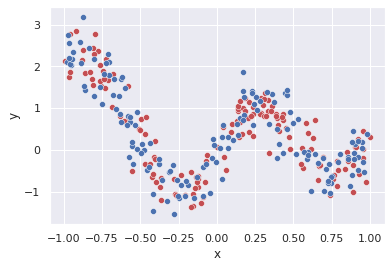

          Data seems to be well shuffled.


In [64]:
plot_colorize(df)
print(" "*9,"Data seems to be well shuffled.")

### Sorted data

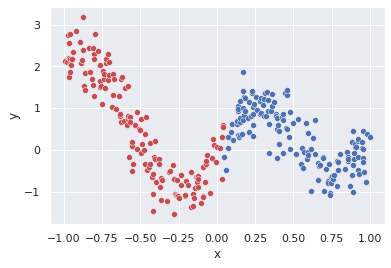

       Data doesn't seem to be well shuffled.


In [65]:
# Sort the data based on 'x' first, then do the 
# previous part to see the result.
sorted_df = df.sort_values(by='x', ascending=True, ignore_index=True)

plot_colorize(sorted_df)
print(" "*6,"Data doesn't seem to be well shuffled.")

### Shuffled data

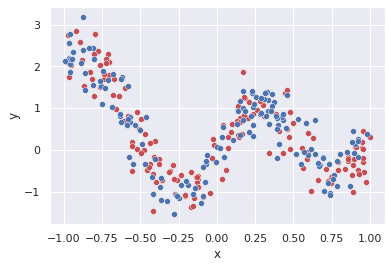

          Data seems to be well shuffled.


In [66]:
# Let's shuffle the data anyways (just in case)

# pandas Doc: specifying drop=True prevents .reset_index()
# from creating a column containing the old index entries.
shuffled_df = df.sample(frac=1).reset_index(drop=True)

plot_colorize(shuffled_df)
print(" "*9,"Data seems to be well shuffled.")

## Part 3 - Gradient Descent
Finding The optimal "Theta" values (weights)

### Data Prepration


#### Add a column for bias

In [67]:
# Add a new column for simplicity of the calculations
# acts as the bias term
shuffled_df = pd.concat([pd.Series(1, index=shuffled_df.index, name='0'), shuffled_df], axis=1)
shuffled_df.head()

,0,x,y
0,1,-0.122797,-0.700428
1,1,0.954990,-0.287307
2,1,-0.087699,-1.126259
3,1,-0.405126,0.206917
4,1,0.154457,0.754608


#### Seperate X,y

In [68]:
# Split training data into X and y
X = shuffled_df.drop(columns="y")
y = shuffled_df.iloc[:, 2]

print("X : \n", X.head().to_string(),end="\n\n")
print("y : \n", y.head().to_string())

X : 
    0         x
0  1 -0.122797
1  1  0.954990
2  1 -0.087699
3  1 -0.405126
4  1  0.154457

y : 
 0   -0.700428
1   -0.287307
2   -1.126259
3    0.206917
4    0.754608


In [69]:
# Split to train and valid
split = train_test_split

X_train = X.iloc[ : int(len(X)*split),:].reset_index(drop=True)
X_valid = X.iloc[int(len(X)*split) : ,:].reset_index(drop=True)

y_train = y.iloc[ : int(len(X)*split)].reset_index(drop=True)
y_valid = y.iloc[int(len(X)*split) : ].reset_index(drop=True)

print(f"Train X size = {len(X_train)}")
print(f"Train y size = {len(y_train)}")
print(f"Valid X size = {len(X_valid)}")
print(f"Valid y size = {len(y_valid)}")

Train X size = 210
Train y size = 210
Valid X size = 90
Valid y size = 90


In [70]:
# Save a copy of X and y 
# TODO might not need it
X_train_org = X_train.copy()
y_train_org = y_train.copy()

### Polynomial Regression
a basic example

In [71]:
# polynomial degree
polynomial_degree = basic_polynomial_degree


Convert

**aX  + bX^2 + cX^3 + d**

to

**aX1 + bX2  + cX3  + d**

In [72]:
# Add the polynomial's terms as features
# so that the univariate non-linear regression
# becomes a multivariate linear regression
# where every polynomial term is a feature for
# the linear regression

X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
polynomial_to_linear_regression(X_train_copy, polynomial_degree)
polynomial_to_linear_regression(X_valid_copy, polynomial_degree)


X_train_copy.head()

,0,x,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,1,-0.122797,0.015079,-0.001852,0.000227,-0.000028,3.428672e-06,-4.210306e-07,5.170128e-08,-6.348761e-09,7.796086e-10
1,1,0.954990,0.912006,0.870957,0.831756,0.794319,7.585666e-01,7.244237e-01,6.918176e-01,6.606791e-01,6.309421e-01
2,1,-0.087699,0.007691,-0.000675,0.000059,-0.000005,4.549648e-07,-3.990011e-08,3.499213e-09,-3.068787e-10,2.691306e-11
3,1,-0.405126,0.164127,-0.066492,0.026938,-0.010913,4.421212e-03,-1.791148e-03,7.256409e-04,-2.939761e-04,1.190974e-04
4,1,0.154457,0.023857,0.003685,0.000569,0.000088,1.357840e-05,2.097281e-06,3.239401e-07,5.003488e-08,7.728246e-09


#### Training a basic example
Normal equation for comparison : 

*   0.07 training loss
*   0.09 validation loss

5k iter 10th degree polynomial lr=2.3
*   Training Loss : 0.07766969752936674
*   Validation Loss : 0.094857479611961




In [73]:
# Initialize the weights with zero
theta = np.array([0.0]*len(X_train_copy.columns))

# Initialize the weights with random values
# theta = np.random.rand(len(X_train_copy.columns),)

print("notice : takes approximately 1 minute for 1k iters (MSE)")

# tip : nice way to find decay (https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
# Decay = LearningRate / Epochs
# Decay = 0.1 / 1000
# Decay = 0.0001
# Note : didn't work well for us :(

# Hyper-Parameters
iterations = basic_iterations
learning_rate = basic_learning_rate
decay = basic_decay

# Start the training
history, loss, theta = gradientDescent(X_train_copy,
                                       y_train,
                                       theta,
                                       learning_rate,
                                       iterations,
                                       X_valid = X_valid_copy,
                                       y_valid = y_valid,
                                       loss_fn=MSE,
                                       loss_fn_prim=MSE_prim,
                                       decay = decay*0)



notice : takes approximately 1 minute for 1k iters (MSE)


  0%|          | 0/1000 [00:00<?, ?it/s]

training_loss : 0.1107 | validation_loss : 0.1162


##### Plotting the fitted polynomials

In [74]:
# Predicting using the learned weights(theta)
# Not used here but useful
y_hat = theta*X_valid_copy
y_hat = np.sum(y_hat, axis=1)
print(RMSE(X_valid_copy, y_valid, theta))

0.34090818758488145


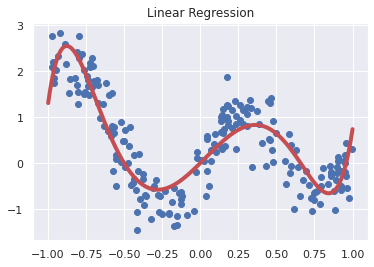

Training Loss : 0.3327509590452109
Validation Loss : 0.34090818758488145



In [75]:
plot_curve(X_train_copy, y_train, theta, title='Linear Regression')

print(f"Training Loss : {RMSE(X_train_copy, y_train, theta)}")
print(f"Validation Loss : {RMSE(X_valid_copy, y_valid, theta)}\n")

##### Plotting losses

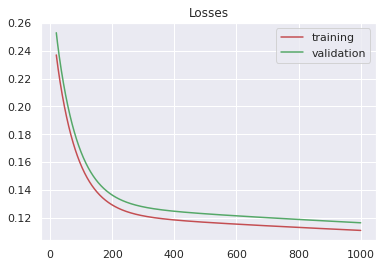

In [76]:
plot_loss(history, starting_iter=20, title='Losses')

##### Plotting the learning rate

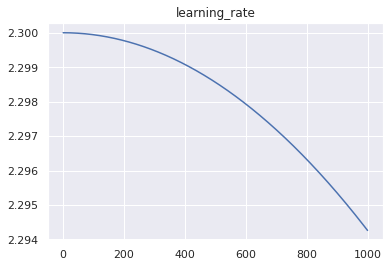

In [77]:
plot_lr(lr=learning_rate, iterations=iterations, decay=decay)

##### Interactive history viewer
You can use the slider to see a history of thetas

which should allow you to look at the progression

of the minization algorithm!

In [78]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(iteration = widgets.IntSlider(min=0, max=iterations-1, step=10, value=0))
def plot_weight_history(iteration):
  plot_curve(X_train_copy, y_train, history["weights"][iteration])

print("Use the slider to see the algorithms progression")

interactive(children=(IntSlider(value=0, description='iteration', max=999, step=10), Output()), _dom_classes=(…

Use the slider to see the algorithms progression


## Part 4 - Plotting every Case!
Polynomial Degree : 
*   5
*   8
*   10

Loss Functions :
*   MSE
*   RMSE
*   MAE

Iterations :
*   1000
*   10000



In [79]:
# Global Hyper-Parameters
# we plot the 'max_iteration' curve (green)
# and 'other_iteration_to_display' curve (red)
iterations = max_iterations
other_iteration_to_display = iterations//10 # The red line in the plots ()

# Grid Hyper-Parameters
polynomial_degrees = [10, 8, 5]

loss_functions = [(MAE, MAE_prim),
                  (RMSE, RMSE_prim),
                  (MSE, MSE_prim)]
fn_labels = ["MAE", "RMSE", "MSE"]

#         MAE  RMSE  MSE
lrs    = [0.26, 1.4, 2.23]
decays = [0,  0,  5e-9]

#### Training all 9 models

In [80]:
# Containers used for storing results about each model
# Used later by the plotting functions
thetas = [[[],[],[]],
          [[],[],[]],
          [[],[],[]]]

losses = [[[],[],[]],
          [[],[],[]],
          [[],[],[]]]

histories = [[[],[],[]],
             [[],[],[]],
             [[],[],[]]]

# start the training process for each model
for i,degree in enumerate(polynomial_degrees):
  for j, (loss_fn, loss_fn_prim) in enumerate(loss_functions):
    print(f"degree: {degree} | loss function: {fn_labels[j]}")
    
    # preprocess data (univariate non-linear to multivariate linear)
    X_train_copy = X_train.copy()
    X_valid_copy = X_valid.copy()
    polynomial_to_linear_regression(X_train_copy, degree)
    polynomial_to_linear_regression(X_valid_copy, degree)

    # Initialize the weights with random values
    theta = np.random.rand(len(X_train_copy.columns),)

    # j(loss function) specific learning rate
    _learning_rate = lrs[j]

    # j(loss function) specific decay value
    _decay = decays[j]

    # Start the training
    history, loss, theta = gradientDescent(X_train_copy,
                                          y_train,
                                          theta,
                                          _learning_rate,
                                          iterations,
                                          X_valid = X_valid_copy,
                                          y_valid = y_valid,
                                          loss_fn = loss_fn,
                                          loss_fn_prim = loss_fn_prim,
                                          decay = _decay)

    # Saving latest iteration's theta for each model
    thetas[i][j].append(history["weights"][-1])
    # Saving halfway theta for each model
    thetas[i][j].append(history["weights"][int(other_iteration_to_display)-1]) # -1 : zero-indexed

    # Saving Training loss for each model
    losses[i][j].append(loss_fn(X_train_copy, y_train, theta))
    # Saving Validation loss for each model
    losses[i][j].append(loss_fn(X_valid_copy, y_valid, theta))
    # Saving Histories for each model (used for plotting loss per iteration)
    histories[i][j].append(history)

    print()

degree: 10 | loss function: MAE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.172 | validation_loss : 0.1766

degree: 10 | loss function: RMSE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.2825 | validation_loss : 0.2919

degree: 10 | loss function: MSE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.0807 | validation_loss : 0.0858

degree: 8 | loss function: MAE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.179 | validation_loss : 0.1819

degree: 8 | loss function: RMSE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.2991 | validation_loss : 0.3059

degree: 8 | loss function: MSE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.0904 | validation_loss : 0.0945

degree: 5 | loss function: MAE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.1732 | validation_loss : 0.1739

degree: 5 | loss function: RMSE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.3066 | validation_loss : 0.314

degree: 5 | loss function: MSE


  0%|          | 0/10000 [00:00<?, ?it/s]

training_loss : 0.094 | validation_loss : 0.0986



##### Plotting fitted curves


<Figure size 432x288 with 0 Axes>

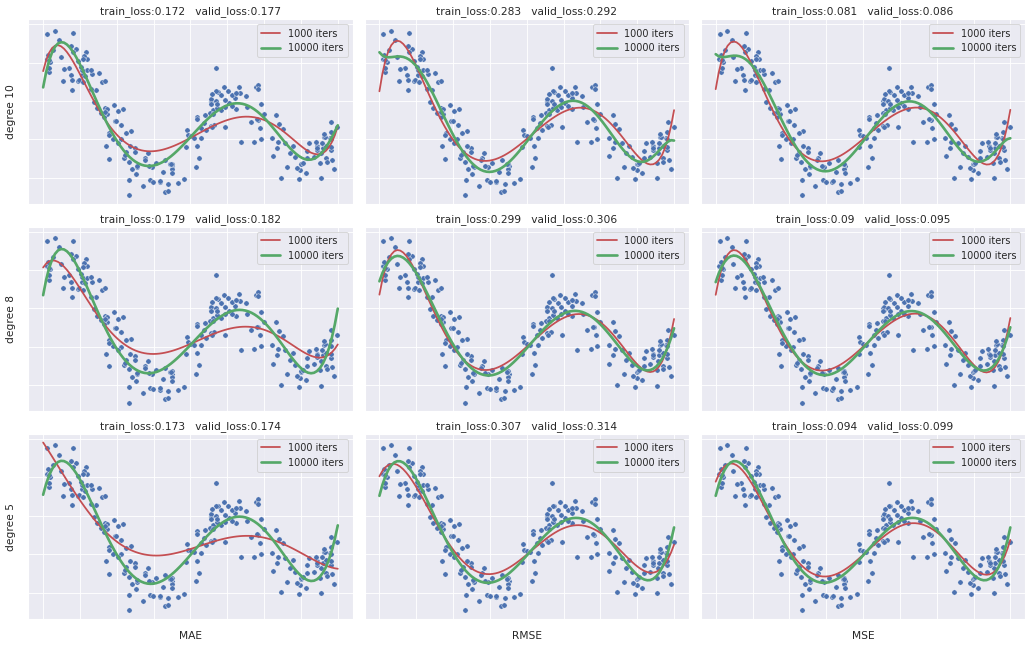

In [97]:
plot_every_curve(X_train,
                 y_train,
                 thetas,
                 line_widths=[3,2],
                 i_max=len(polynomial_degrees),
                 j_max=len(loss_functions),
                 dpi=64)

##### Plotting train/valid loss

<Figure size 432x288 with 0 Axes>

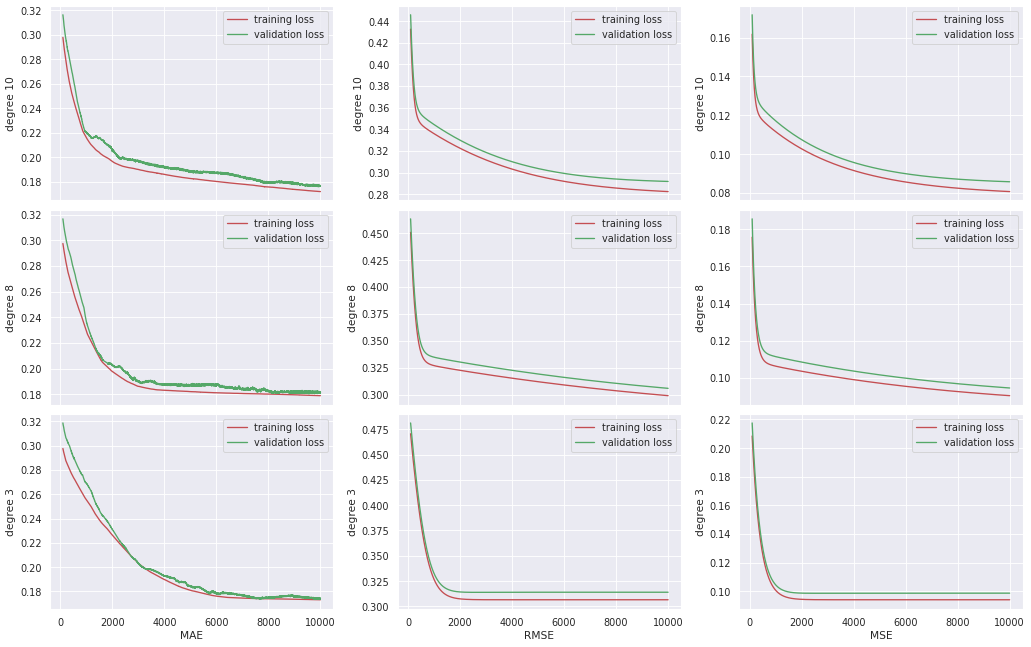

In [98]:
plot_every_case_loss(histories,
                     starting_iter=100,
                     i_max=len(polynomial_degrees),
                     j_max=len(loss_functions),
                     dpi=64)

##### Plotting Learning Rate

MAE | initial learning rate = 0.26 | decay=0


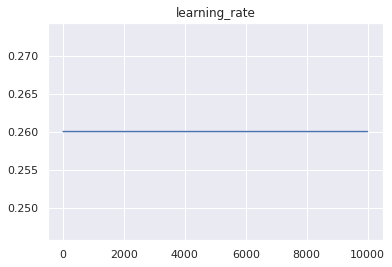


RMSE | initial learning rate = 1.4 | decay=0


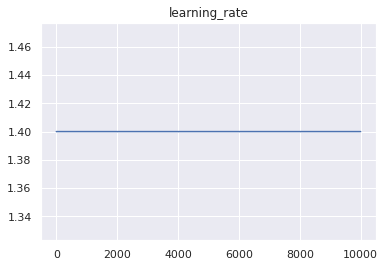


MSE | initial learning rate = 2.23 | decay=5e-09


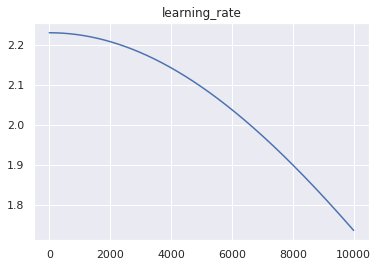

In [83]:
for lr, decay, fn_name in zip(lrs, decays, fn_labels):
  print(f"{fn_name} | initial learning rate = {lr} | decay={decay}")
  plot_lr(lr=lr, iterations=iterations, decay=decay)
  print()

## Part 5 - Normal Equation


In [84]:
# preprocess data (univariate non-linear to multivariate linear)
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
polynomial_to_linear_regression(X_train_copy, 8)
polynomial_to_linear_regression(X_valid_copy, 8)

In [85]:
normal_theta = normalEquation(X_train_copy, y_train)

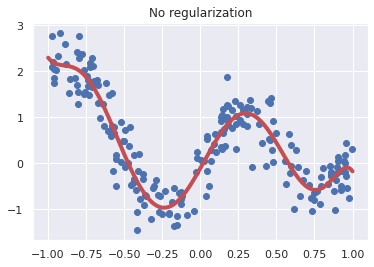

Training Loss(RMSE) : 0.27755996509703385


In [86]:
# Plotting the fitted polynomial over training data
plot_curve(X_train_copy, y_train, normal_theta, title="No regularization")
print(f"Training Loss(RMSE) : {RMSE(X_train_copy, y_train, normal_theta)}")

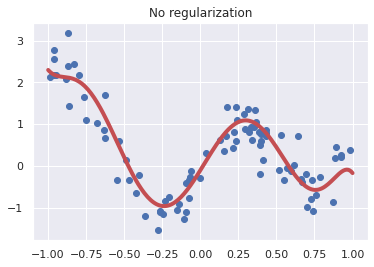

Validation Loss : 0.2878978107333649



In [87]:
# Plotting the fitted polynomial over validation data
plot_curve(X_valid_copy, y_valid, normal_theta, title="No regularization")
print(f"Validation Loss : {RMSE(X_valid_copy, y_valid, normal_theta)}\n")

## Part 6 - Regularized Normal Equation

In [88]:
loss_fn = RMSE # as asked in the question

reg_normal_theta1 = regularizedNormalEquation(X_train_copy, y_train, lambd=0.075)
# plot_curve(X_train, y_train, reg_normal_theta, title="lambda=0.1")
reg_normal_theta2 = regularizedNormalEquation(X_train_copy, y_train, lambd=0.75)
# plot_curve(X_train, y_train, reg_normal_theta, title="lambda=1")
reg_normal_theta3 = regularizedNormalEquation(X_train_copy, y_train, lambd=7.5)
# plot_curve(X_train, y_train, reg_normal_theta, title="lambda=4")

In [89]:
names = ["λ = 0.075", "λ = 0.75", "λ = 7.5"]

training_errors = [round(loss_fn(X_train_copy, y_train, reg_normal_theta1),5),
                   round(loss_fn(X_train_copy, y_train, reg_normal_theta2),5),
                   round(loss_fn(X_train_copy, y_train, reg_normal_theta3),5)]

validation_errors =[round(loss_fn(X_valid_copy, y_valid, reg_normal_theta1),5),
                    round(loss_fn(X_valid_copy, y_valid, reg_normal_theta2),5),
                    round(loss_fn(X_valid_copy, y_valid, reg_normal_theta3),5)]

for i in range(len(names)):
  print(f"{i} - Regularized Normal Equation ({names[i]})")
  print(f"Training Loss : {training_errors[i]}")
  print(f"Validation Loss : {validation_errors[i]}\n")

0 - Regularized Normal Equation (λ = 0.075)
Training Loss : 0.33571
Validation Loss : 0.34334

1 - Regularized Normal Equation (λ = 0.75)
Training Loss : 0.43287
Validation Loss : 0.44485

2 - Regularized Normal Equation (λ = 7.5)
Training Loss : 0.51534
Validation Loss : 0.53339



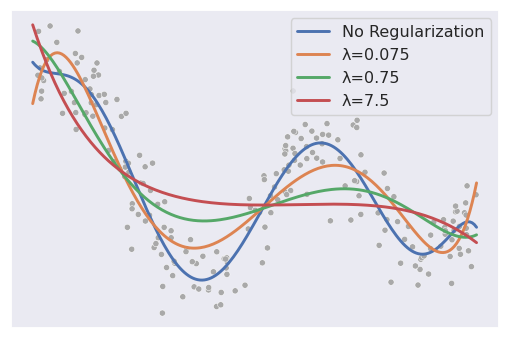

In [96]:
plot_normal_equations(X_train, y_train, dpi=105)

Thanks for reading.
if you have any questions:
* gholamrezadar@gmail.com
* instagram : @gholamreza_dar
* telegram  : @gholamrezadar